In [1]:
import pathlib
import pickle

import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import cmasher as cmr

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
import galstreams
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
from astropy.stats import median_absolute_deviation as MAD
from ezpadova import parsec
from gala.units import galactic
from pyia import GaiaData
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import minimize
from tqdm.auto import tqdm

In [2]:
mwstreams = galstreams.MWStreams()

Initializing galstreams library from master_log... 


In [3]:
Z = 10 ** (-2.2 + np.log10(0.0207))
iso = parsec.get_one_isochrone(12e9, Z, model="parsec12s", phot="panstarrs1")
iso = iso.to_astropy_table()

iso_gaia = parsec.get_one_isochrone(12e9, Z, model="parsec12s", phot="gaia")
iso_gaia = iso_gaia.to_astropy_table()
iso_gaia.remove_columns([x for x in iso_gaia.colnames if x in iso.colnames])

iso = at.hstack((iso, iso_gaia))

tmp_iso = iso[iso["stage"] == 4][1:]
HB_absmag = np.mean(tmp_iso["rP1"])

tmp_iso = iso[iso["stage"] == 1]
MSTO_absmag = tmp_iso["rP1"].min()

Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...


## Load data:

In [4]:
# tbl = at.Table.read("../data/Ibata2023_Table1.csv")
g = GaiaData(
    "../data/Ibata2023_GaiaDR3-xm.fits",
    radial_velocity_colname="vh",
    radial_velocity_unit=u.km / u.s,
)

In [5]:
tbl = at.Table.read("../data/ibata_streams_full.csv")
sID_to_name = {row["sID"]: row["name"] for row in at.unique(tbl, keys="sID")}
name_to_sID = {v: k for k, v in sID_to_name.items()}

In [6]:
dist = g.get_distance(allow_negative=True)
dist[~np.isfinite(dist)] = 100 * u.kpc

c = g.get_skycoord(distance=dist)
# c = coord.SkyCoord(
#     ra=tbl["ra"] * u.deg,
#     dec=tbl["dec"] * u.deg,
#     distance=dist,
#     pm_ra_cosdec=tbl["mu_r"] * u.mas / u.yr,
#     pm_dec=tbl["mu_d"] * u.mas / u.yr,
#     radial_velocity=tbl["vh"] * u.km / u.s,
# )

In [7]:
gal = c.galactic

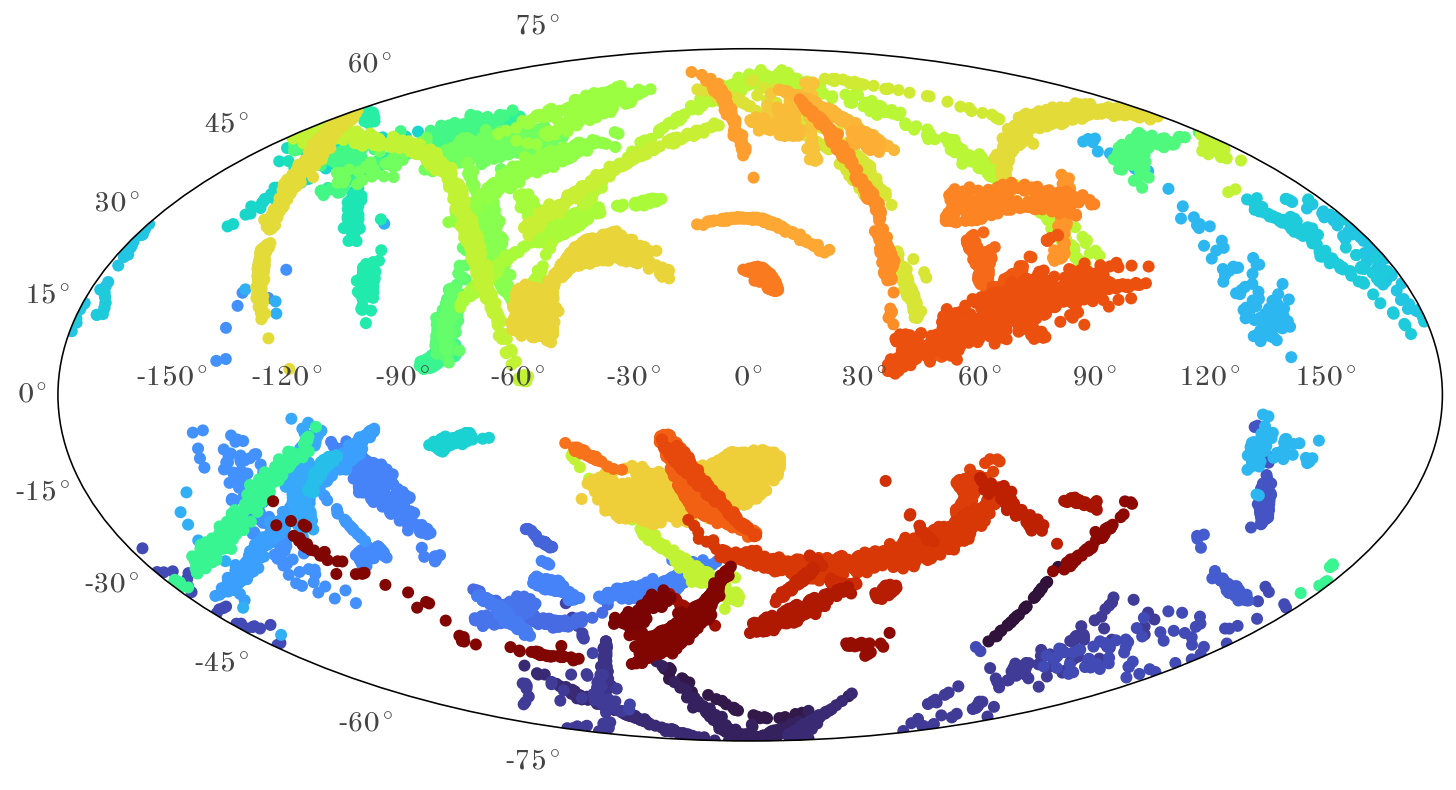

In [8]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": "aitoff"})
ax.scatter(gal.l.wrap_at(180 * u.deg).radian, gal.b.radian, c=tbl["sID"], cmap="turbo")

In [9]:
def get_frame_from_points(c):
    """
    Parameters
    ----------
    c : astropy.coordinates.SkyCoord
        Must have sky coordinates for a set of stars.
    """
    u_xyz = (
        c.data.represent_as(coord.UnitSphericalRepresentation).to_cartesian().xyz.value
    )

    # Initial guess of the direction that the stream spreads in, based on eigenvectors:
    eig_res = np.linalg.eig(np.cov(u_xyz))

    proj = u_xyz.T @ eig_res.eigenvectors[:, 0]
    idx = np.argsort(proj)
    frame = gc.GreatCircleICRSFrame.from_endpoints(c[idx[0]], c[idx[-1]])

    # Now we will make fine adjustments to the orientation of the frame to get the
    # stream to lie near phi2=0

    # The initial rotation matrix from the endpoints above:
    R = np.zeros((3, 3))
    R[0] = frame.origin.cartesian.xyz
    R[2] = frame.pole.cartesian.xyz
    R[1] = np.cross(R[:, 0], R[:, 2])

    def frame_adjust(rot_x, rot_y):
        Rx = coord.matrix_utilities.rotation_matrix(rot_x * u.deg, "x")
        Ry = coord.matrix_utilities.rotation_matrix(rot_y * u.deg, "y")
        new_R = Rx @ Ry @ R
        return gc.GreatCircleICRSFrame.from_R(new_R)

    def objective(p):
        new_frame = frame_adjust(p[0], p[1])
        c_fr = c.transform_to(new_frame)
        return np.sum(c_fr.phi2.degree**2)

    res = minimize(objective, x0=[0.0, 0.0], bounds=[[-30, 30], [-20, 20]])
    return frame_adjust(*res.x)

In [10]:
galcen_frame = coord.Galactocentric(
    galcen_distance=8.275 * u.kpc, galcen_v_sun=[8.4, 251, 8.4] * u.km / u.s
)


def get_w0_from_p(p, frame):
    # At phi1 = 0.
    orbit_w0_fr = coord.SkyCoord(
        phi1=0 * u.deg,
        phi2=p["phi2"] * u.deg,
        distance=p["distance"] * u.kpc,
        pm_phi1_cosphi2=p["pmphi1"] * u.mas / u.yr,
        pm_phi2=p["pmphi2"] * u.mas / u.yr,
        radial_velocity=p["rv"] * u.km / u.s,
        frame=frame,
    )
    orbit_w0_galcen = orbit_w0_fr.transform_to(galcen_frame)
    return gd.PhaseSpacePosition(orbit_w0_galcen.data)


def p_arr_to_dict(p):
    return {
        "phi2": p[0],
        "distance": p[1],
        "pmphi1": p[2],
        "pmphi2": p[3],
        "rv": p[4],
    }


def get_orbit(mw, orbit_w0, int_time):
    orbit1 = mw.integrate_orbit(orbit_w0, dt=-0.5, t1=0, t2=-2 * int_time)
    orbit2 = mw.integrate_orbit(orbit_w0, dt=0.5, t1=0, t2=2 * int_time)

    orbit_xyz = np.hstack((orbit1[::-1].xyz, orbit2[1:].xyz))
    orbit_vxyz = np.hstack((orbit1[::-1].v_xyz, orbit2[1:].v_xyz))
    orbit_t = np.concatenate((orbit1[::-1].t, orbit2.t[1:]))
    orbit = gd.Orbit(orbit_xyz, orbit_vxyz, t=orbit_t)[::-1]
    return orbit


def get_orbit_from_p(mw, p, c_fr):
    phi1_size = c_fr.phi1.radian.max() - c_fr.phi1.radian.min()
    orbit_w0 = get_w0_from_p(p, c_fr.frame)

    # Old way:
    # int_time = (
    #     (phi1_size * p["distance"] * u.kpc) / np.linalg.norm(orbit_w0.v_xyz)
    # ).to(u.Myr)
    int_time = (
        (phi1_size * u.radian)
        / (np.sqrt(p["pmphi1"] ** 2 + p["pmphi2"] ** 2) * u.mas / u.yr)
    ).to_value(u.Myr)
    int_time = np.max([int_time, 100.0]) * u.Myr

    orbit = get_orbit(mw, orbit_w0, int_time)
    return orbit


def cut_wrapped_orbit(orbit, orbit_fr):
    idx = np.where(np.abs(np.diff(orbit_fr.phi1.wrap_at(180 * u.deg).degree)) > 180)[0]

    orbit_mask = np.ones(orbit.ntimes, dtype=bool)
    for i in idx:
        wrap_time = orbit.t[i]
        if wrap_time > 0:
            orbit_mask &= orbit.t < wrap_time
        else:
            orbit_mask &= orbit.t > wrap_time
    return orbit[orbit_mask], orbit_fr[orbit_mask]


def ln_likelihood(p, c_fr, data, mw):
    orbit = get_orbit_from_p(mw, p, c_fr)
    orbit_fr = orbit.to_coord_frame(c_fr.frame, galactocentric_frame=galcen_frame)

    # if the orbit wraps, need to cut it off at +/- 180º!
    orbit, orbit_fr = cut_wrapped_orbit(orbit, orbit_fr)

    # fig, ax = plt.subplots()
    # ax.plot(orbit.t.value[1:], np.diff(orbit_fr.phi1.degree))

    # fig, ax = plt.subplots(figsize=(10, 5))
    # ax.scatter(c_fr.phi1.degree, c_fr.phi2.degree, s=3)
    # ax.plot(orbit_fr.phi1.degree, orbit_fr.phi2.degree, marker='')

    interps = {}
    units = {}
    for name in ["phi2", "distance", "pm_phi1_cosphi2", "pm_phi2", "radial_velocity"]:
        comp = getattr(orbit_fr, name)
        x = orbit_fr.phi1.wrap_at(180 * u.deg).degree
        idx = np.argsort(x)
        interps[name] = InterpolatedUnivariateSpline(x[idx], comp[idx], k=3)
        units[name] = comp.unit

    ll = 0.0
    for name in interps:
        if name == "phi2":
            err = 0.05
        elif name == "distance":
            err = data["parallax_error"]
        else:
            err = data[f"{name}_error"]

        model_y = interps[name](c_fr.phi1.wrap_at(180 * u.deg).degree)

        if name == "distance":
            y = data["parallax"]
            model_y = c_fr.distance.parallax.to_value(u.mas)
        else:
            y = getattr(c_fr, name).to_value(units[name])
        ll += -0.5 * (model_y - y) ** 2 / err**2

    return ll

## Fit orbits:

In [11]:
def objective(p, *args, **kwargs):
    p = p_arr_to_dict(p)
    lls = ln_likelihood(p, *args, **kwargs)
    return -np.sum(lls) / len(lls)

In [12]:
mw = gp.MilkyWayPotential2022()

In [13]:
data_file = pathlib.Path("../data/stream-orbit-fits.pkl")

if not data_file.exists():
    all_data = {}

    for sid in tqdm(np.unique(tbl["sID"])):
        # print(sID_to_name[sid])
        mask = tbl["sID"] == sid
        rows = g[mask]

        frame = get_frame_from_points(c[mask])
        c_fr = c[mask].transform_to(frame)

        C, _ = rows.get_cov(coords=["pmra", "pmdec"])
        C_pm_fr = gc.transform_pm_cov(c[mask], C, frame)
        pm1_err = np.sqrt(C_pm_fr[:, 0, 0])
        pm2_err = np.sqrt(C_pm_fr[:, 1, 1])
        obj_data = {
            "parallax": rows.parallax.value,
            "parallax_error": rows.parallax_error.value,
            "pm_phi1_cosphi2_error": pm1_err,
            "pm_phi2_error": pm2_err,
            "radial_velocity_error": rows.evh,
        }

        idx = np.argsort(np.abs(c_fr.phi1.wrap_at(180 * u.deg).degree))
        phi2 = np.nanmedian(c_fr.phi2.to_value(u.deg)[idx][:8])
        pm_phi1 = np.nanmean(c_fr.pm_phi1_cosphi2[idx][:8])
        pm_phi2 = np.nanmean(c_fr.pm_phi2[idx][:8])
        rv = np.nanmean(rows["vh"][rows["vh"] != 0.0])

        init_dists = np.geomspace(1, 40, 6)
        reses = []
        for d0 in init_dists:
            p0 = {
                "phi2": phi2,
                "distance": d0,
                "pmphi1": pm_phi1.value,
                "pmphi2": pm_phi2.value,
                "rv": rv.value,
            }
            try:
                res = minimize(
                    objective,
                    list(p0.values()),
                    bounds=[[-5, 5], [0.5, 50], [-100, 100], [-100, 100], [-500, 500]],
                    args=(c_fr, obj_data, mw),
                    method="L-BFGS-B",
                    options={"ftol": 1e-10, "gtol": 1e-10},
                )
            except Exception as err:
                print(f"{sid} failed with an exception: ")
                print(err)
                continue

            if not res.success:
                continue

            reses.append(res)

        if len(reses) == 0:
            print(f"{sid} failed: {res.nit}")
            continue
        elif len(reses) == 1:
            res = reses[0]
        else:
            i = np.argmin([r.fun for r in reses])
            res = reses[i]

        res_p = p_arr_to_dict(res.x)
        orbit = get_orbit_from_p(mw, res_p, c_fr)
        orbit_fr = orbit.to_coord_frame(c_fr.frame, galactocentric_frame=galcen_frame)

        # Store stuff:
        this_data = {}
        this_data["c_fr"] = c_fr
        this_data["obj_data"] = obj_data
        this_data["p"] = res_p
        this_data["orbit"] = orbit
        this_data["orbit_fr"] = orbit_fr
        all_data[sid] = this_data

    with open(data_file, "wb") as f:
        pickle.dump(all_data, f)

else:
    with open(data_file, "rb") as f:
        all_data = pickle.load(f)

In [14]:
def make_components_plot(orbit, orbit_fr, c_fr, obj_data):
    orbit, orbit_fr = cut_wrapped_orbit(orbit, orbit_fr)

    comps = ["phi2", "parallax", "pm_phi1_cosphi2", "pm_phi2", "radial_velocity"]
    fig, axes = plt.subplots(
        len(comps), 1, figsize=(8, len(comps) * 2.5), sharex=True, layout="constrained"
    )
    err_style = dict(ls="none", marker="o", ms=3, color="k")
    for i, name in enumerate(comps):
        ax = axes[i]
        if name == "parallax":
            ax.plot(
                orbit_fr.phi1.degree,
                orbit_fr.distance.parallax.to_value(u.mas),
                marker="",
                color="tab:blue",
            )
            ax.errorbar(
                c_fr.phi1.degree,
                obj_data["parallax"],
                obj_data["parallax_error"],
                **err_style,
            )

        else:
            ax.plot(
                orbit_fr.phi1.degree,
                getattr(orbit_fr, name).value,
                marker="",
                color="tab:blue",
            )

            y = getattr(c_fr, name).value
            y_mask = ~np.isclose(y, 0.0)
            if f"{name}_error" in obj_data:
                ax.errorbar(
                    c_fr.phi1.degree[y_mask],
                    y[y_mask],
                    obj_data[f"{name}_error"][y_mask],
                    **err_style,
                )
            else:
                ax.scatter(c_fr.phi1.degree[y_mask], y[y_mask], s=3)

        ax.set_ylabel(name)
    ax.set_xlim(-100, 100)
    axes[-1].set_xlabel("phi1")
    return fig, axes

In [20]:
# plot_path = pathlib.Path("../plots").resolve()
# plot_path.mkdir(exist_ok=True)

# for sid, this_data in all_data.items():
#     fig, _ = make_components_plot(
#         this_data["orbit"],
#         this_data["orbit_fr"],
#         this_data["c_fr"],
#         this_data["obj_data"],
#     )
#     fig.suptitle(sID_to_name[sid], fontsize=20)
#     fig.savefig(plot_path / f"stream-{sid:04d}-orbitfit.png", dpi=200)
#     plt.close(fig)

In [21]:
fit_tbl = at.Table(
    [{"sID": sid, "name": sID_to_name[sid], **d["p"]} for sid, d in all_data.items()]
)

From visual inspection of plots:

In [22]:
failed = [
    21,
    28,
    48,  # Orphan
    77,
]

In [23]:
pre_gaia_ibata = ["Orphan", "GD-1", "NGC5466", "Pal5", "Ophiuchus", "Jhelum", "Tuc3"]

## S5 streams:
s5_streams = "300S", "Willka Yaku", "AAU", "Jet", "Phoenix", "Indus", "Palca", "Elqui", "Turranburra",

Distance modulus functions are from Li et al 2022, Table 1

In [24]:
rows = []

stream = mwstreams["300S-F18"]
track = stream.track.transform_to(stream.stream_frame)
rows.append(
    {
        "name": "300S",
        "phi1": track.phi1.wrap_at(180 * u.deg).degree,
        "phi2": track.phi2.degree,
        "distmod": 48.9952 - 0.2083 * stream.track.ra.degree,
        "mass": 10
        ** 4.7,  # https://ui.adsabs.harvard.edu/abs/2024MNRAS.tmp..241U/abstract -- TODO: cite
    }
)

stream = mwstreams["Willka_Yaku-S18"]
track = stream.track.transform_to(stream.stream_frame)
rows.append(
    {
        "name": "Willka Yaku",
        "phi1": track.phi1.wrap_at(180 * u.deg).degree,
        "phi2": track.phi2.degree,
        "distmod": np.full(len(track), 17.8),
        "mass": 14e4,  # Shipp+2018
    }
)

stream = mwstreams["AAU-ATLAS-L21"]
track_phi1 = np.concatenate(
    (
        mwstreams["AAU-ATLAS-L21"]
        .track.transform_to(mwstreams["AAU-ATLAS-L21"].stream_frame)
        .phi1.wrap_at(180 * u.deg)
        .degree,
        mwstreams["AAU-AliqaUma-L21"]
        .track.transform_to(mwstreams["AAU-ATLAS-L21"].stream_frame)
        .phi1.wrap_at(180 * u.deg)
        .degree,
    )
)
track_phi2 = np.concatenate(
    (
        mwstreams["AAU-ATLAS-L21"]
        .track.transform_to(mwstreams["AAU-ATLAS-L21"].stream_frame)
        .phi2.degree,
        mwstreams["AAU-AliqaUma-L21"]
        .track.transform_to(mwstreams["AAU-ATLAS-L21"].stream_frame)
        .phi2.degree,
    )
)
rows.append(
    {
        "name": "AAU",
        "phi1": track_phi1,
        "phi2": track_phi2,
        "distmod": 16.67 - 0.034 * track_phi1,
        "mass": (12e4 + 18e4),  # Shipp+2018
    }
)

distmod_trends = {
    "Jet-F22": lambda x: 17.45 - 0.014 * x,
    "Phoenix-S19": lambda x: 16.26 + 0.008 * x,
    "Indus-S19": lambda x: 15.90 - 0.016 * x,
    "Palca-S18": lambda x: np.full_like(x, 17.8),
    "Elqui-S19": lambda x: 18.48 - 0.043 * x,
    "Turranburra-S19": lambda x: np.full_like(x, 17.1),
}
masses = {
    "Jet-F22": 2.5e4,  # TODO: cite Jethwa
    "Phoenix-S19": 3e4,
    "Indus-S19": 650e4,
    "Palca-S18": 1e6,  # https://ui.adsabs.harvard.edu/abs/2022A%26A...660A..29T/abstract - TODO: cite
    "Elqui-S19": 320e4,
    "Turranburra-S19": 180e4,
}
for key, trend in distmod_trends.items():
    stream = mwstreams[key]
    track = stream.track.transform_to(stream.stream_frame)
    track_phi1 = track.phi1.wrap_at(180 * u.deg).degree
    rows.append(
        {
            "name": key.split("-")[0],
            "phi1": track_phi1,
            "phi2": track.phi2.degree,
            "distmod": trend(track_phi1),
            "mass": masses[key],
        }
    )

s5_data = at.Table(rows)

---

In [25]:
pre_gaia_colors = cmr.get_sub_cmap(
    "cmr.infinity", 0.0, 0.5, N=len(pre_gaia_ibata) + len(s5_data)
).colors
other_colors = cmr.get_sub_cmap(
    "cmr.infinity", 0.5, 1.0, N=len(all_data) - len(pre_gaia_ibata)
).colors

Text(0, 0.5, 'MSTO $r$ magnitude')

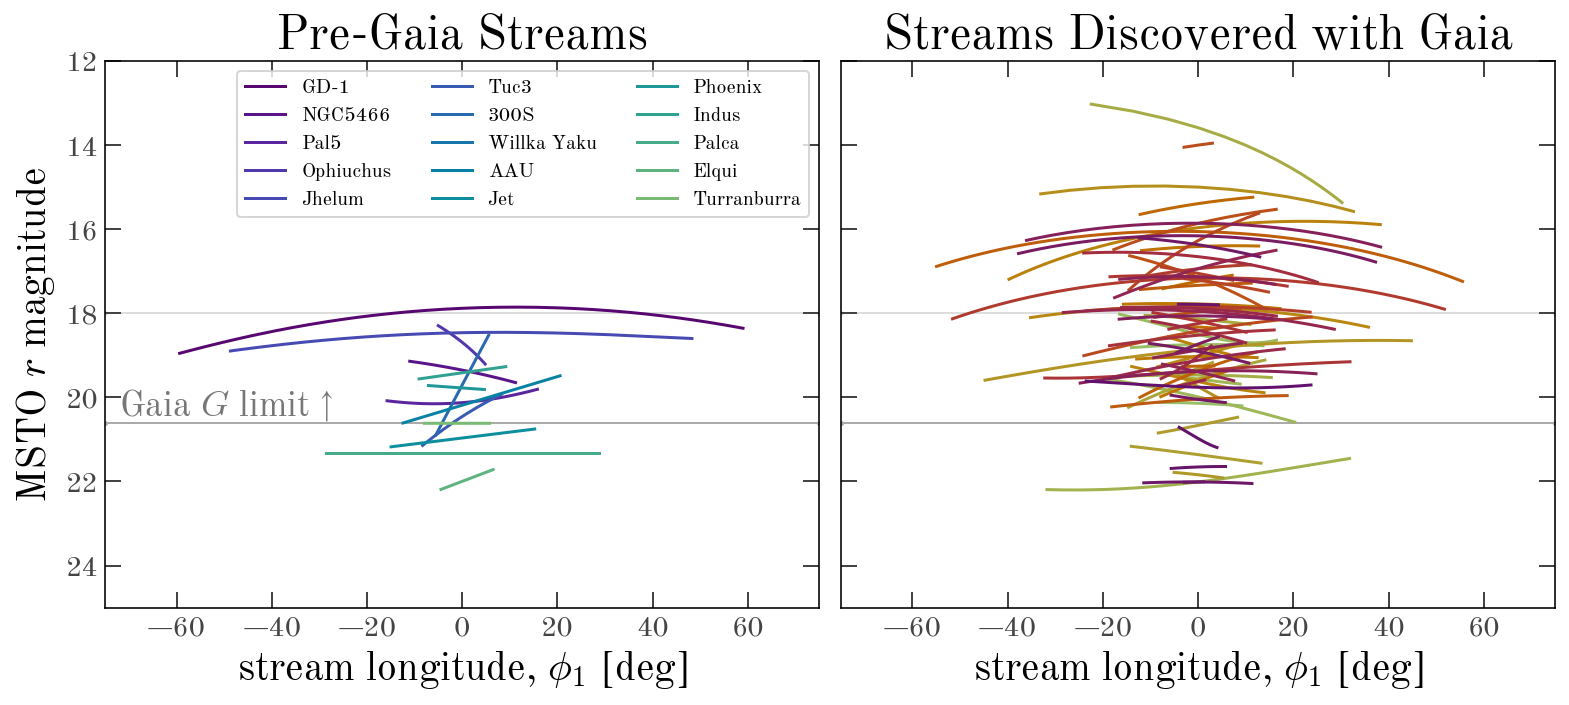

In [26]:
fig, axes = plt.subplots(
    1, 2, figsize=(11, 5), layout="tight", sharex=True, sharey=True
)

pg_i = 0
oth_i = 0
for sid, d in all_data.items():
    if sid in failed:
        continue

    name = sID_to_name[sid]

    phi1_lim = (d["c_fr"].phi1.degree.min(), d["c_fr"].phi1.degree.max())
    orbit_phi1_mask = (d["orbit_fr"].phi1.degree >= phi1_lim[0]) & (
        d["orbit_fr"].phi1.degree <= phi1_lim[1]
    )

    DM = d["orbit_fr"].distance.distmod.value
    HB_r = DM + HB_absmag
    MSTO_r = DM + MSTO_absmag

    # print(sid, DM[orbit_phi1_mask], MSTO_r[orbit_phi1_mask])

    if name in pre_gaia_ibata:
        ax = axes[0]
        c = pre_gaia_colors[pg_i]
        pg_i += 1
    else:
        ax = axes[1]
        c = other_colors[oth_i]
        oth_i += 1
    ax.plot(
        d["orbit_fr"].phi1.degree[orbit_phi1_mask],
        MSTO_r[orbit_phi1_mask],
        marker="",
        label=f"{name}",
        color=c,
    )

for pg_i, row in enumerate(s5_data, start=pg_i):
    c = pre_gaia_colors[pg_i]
    ax.plot(
        row["phi1"],
        row["distmod"] + MSTO_absmag,
        marker="",
        label=f"{row['name']}",
        color=c,
    )

axes[0].legend(ncols=3)

ax.set_xlim(-75, 75)
ax.set_ylim(25, 12)

for ax in axes:
    ax.set_xlabel(r"stream longitude, $\phi_1$ [deg]")
    # ax.axhspan(20.6, max(ax.get_ylim()), linewidth=0, zorder=-100, color='#dddddd')
    ax.axhline(20.6, linewidth=1, zorder=-100, color="#aaaaaa")
    ax.axhline(18, linewidth=1, zorder=-100, color="#dddddd")

axes[0].text(
    ax.get_xlim()[0] + 3,
    20.6,
    "Gaia $G$ limit ↑",
    ha="left",
    va="bottom",
    fontsize=18,
    color="#777777",
)

axes[0].set_title("Pre-Gaia Streams")
axes[1].set_title("Streams Discovered with Gaia")
axes[0].set_ylabel("MSTO $r$ magnitude")

# fig.savefig("../tex/figures/msto-rc-mag.pdf")

Estimate a more realistic spectroscopic limit, based on:
https://www.lco.cl/technical-documentation/the-mike-magellan-inamori-kyocera-echelle-users-guide/

In [27]:
V = 17.0
SNR = 50
R = 30_000
ref_lambda = 5500 * u.angstrom

req = SNR**2 * u.electron / u.pixel
num1 = (
    1.0
    * u.electron
    / u.second
    / u.Angstrom
    * ref_lambda
    / R
    / u.pixel
    * 10 ** (0.4 * (18.4 - V))
    * 0.7
)
(req / num1).to(u.hour)

<Quantity 1.4903835 h>

/var/folders/rt/whnwmp_97v9g6dldf5lr38l80000gr/T/ipykernel_41842/3783385705.py:35: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(
/var/folders/rt/whnwmp_97v9g6dldf5lr38l80000gr/T/ipykernel_41842/3783385705.py:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


Text(0, 0.5, 'MSTO $r$ magnitude')

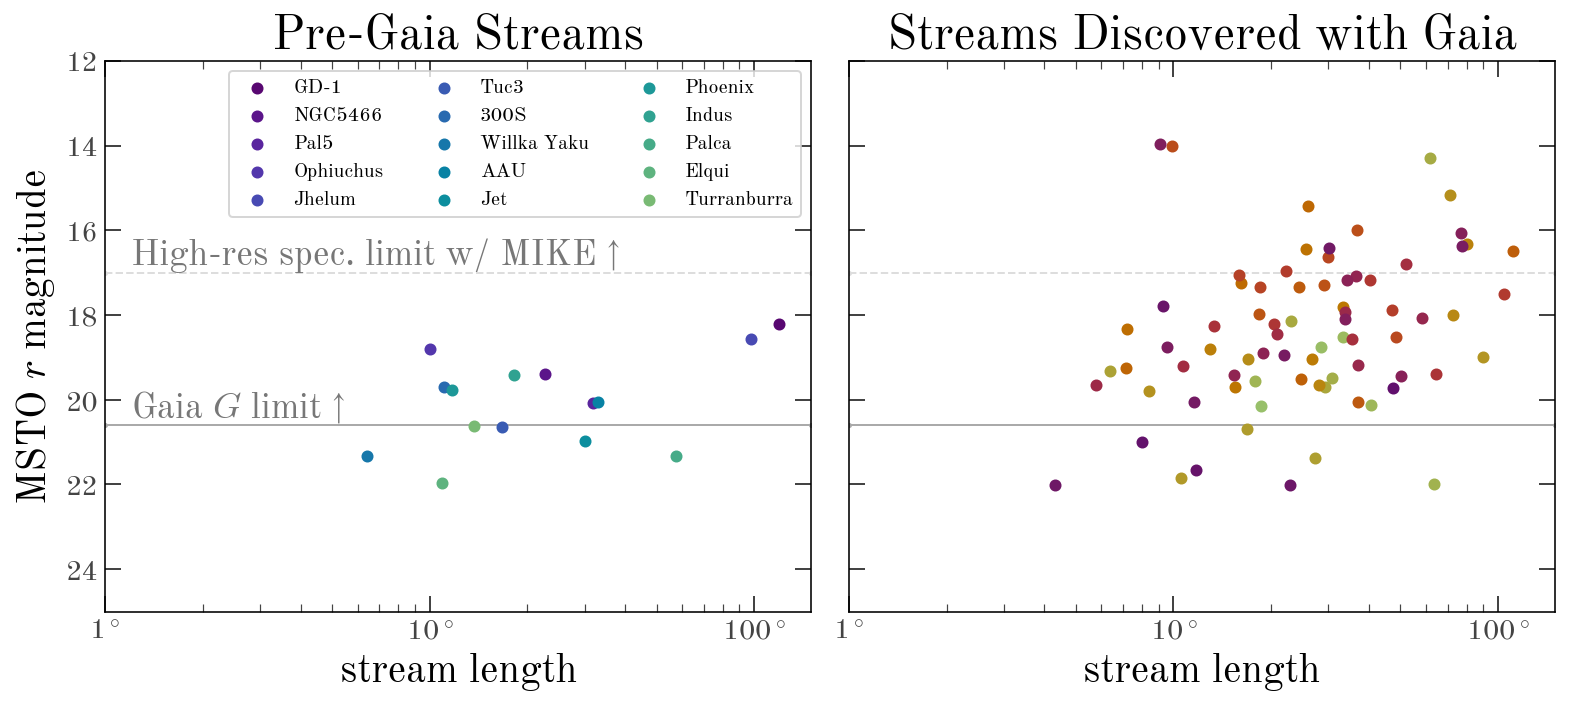

In [28]:
fig, axes = plt.subplots(
    1, 2, figsize=(11, 5), layout="tight", sharex=True, sharey=True
)

pg_i = 0
oth_i = 0
for sid, d in all_data.items():
    if sid in failed:
        continue

    name = sID_to_name[sid]

    phi1_lim = (d["c_fr"].phi1.degree.min(), d["c_fr"].phi1.degree.max())
    size = phi1_lim[1] - phi1_lim[0]
    orbit_phi1_mask = (d["orbit_fr"].phi1.degree >= phi1_lim[0]) & (
        d["orbit_fr"].phi1.degree <= phi1_lim[1]
    )
    DM = np.mean(d["orbit_fr"].distance.distmod.value[orbit_phi1_mask])
    MSTO_r = DM + MSTO_absmag
    # if size < 10:
    #     print(name, DM, MSTO_r)
    #     ax.text(size, MSTO_r, name)
    # else:
    #     continue

    if name in pre_gaia_ibata:
        ax = axes[0]
        c = pre_gaia_colors[pg_i]
        pg_i += 1
    else:
        ax = axes[1]
        c = other_colors[oth_i]
        oth_i += 1

    ax.scatter(
        size,
        MSTO_r,
        marker="o",
        label=f"{name}",
        c=c,
    )

for pg_i, row in enumerate(s5_data, start=pg_i):
    c = pre_gaia_colors[pg_i]
    ax.scatter(
        row["phi1"].max() - row["phi1"].min(),
        np.mean(row["distmod"]) + MSTO_absmag,
        marker="o",
        label=f"{row['name']}",
        c=c,
    )

axes[0].legend(ncols=3)

ax.set(
    xscale="log",
    xlim=(1, 150),
    ylim=(25, 12),
    xticks=[1, 10, 100],
    xticklabels=[r"1$^\circ$", r"10$^\circ$", r"100$^\circ$"],
)

for ax in axes:
    ax.set_xlabel(r"stream length")
    # ax.axhspan(20.6, max(ax.get_ylim()), linewidth=0, zorder=-100, color='#dddddd')
    ax.axhline(20.6, linewidth=1, zorder=-100, color="#aaaaaa")
    ax.axhline(V, linewidth=1, zorder=-100, color="#dddddd", linestyle="--")

axes[0].text(
    ax.get_xlim()[0] + 0.2,
    20.6,
    "Gaia $G$ limit ↑",
    ha="left",
    va="bottom",
    fontsize=18,
    color="#777777",
)

axes[0].text(
    ax.get_xlim()[0] + 0.2,
    V,
    "High-res spec. limit w/ MIKE ↑",
    ha="left",
    va="bottom",
    fontsize=18,
    color="#777777",
)

axes[0].set_title("Pre-Gaia Streams")
axes[1].set_title("Streams Discovered with Gaia")
axes[0].set_ylabel("MSTO $r$ magnitude")

# fig.savefig("../tex/figures/msto-rc-mag.pdf")

In [109]:
pre = {"name": [], "size": [], "r": [], "mass": []}
post = {"name": [], "size": [], "r": [], "mass": []}
for sid, d in all_data.items():
    if sid in failed:
        continue

    name = sID_to_name[sid]

    phi1_lim = (d["c_fr"].phi1.degree.min(), d["c_fr"].phi1.degree.max())
    size = phi1_lim[1] - phi1_lim[0]
    orbit_phi1_mask = (d["orbit_fr"].phi1.degree >= phi1_lim[0]) & (
        d["orbit_fr"].phi1.degree <= phi1_lim[1]
    )
    DM = np.mean(d["orbit_fr"].distance.distmod.value[orbit_phi1_mask])
    MSTO_r = DM + MSTO_absmag

    # Estimate initial stellar mass:
    idx = np.where((iso["G"] + DM) < 20.0)[0]
    dIMF = iso["int_IMF"][idx[-1]] - iso["int_IMF"][idx[0]]
    M = 2.0 * len(d["c_fr"]) / dIMF

    if name in pre_gaia_ibata:
        pre["name"].append(name)
        pre["size"].append(size)
        pre["r"].append(MSTO_r)
        pre["mass"].append(M)
    else:
        post["name"].append(name)
        post["size"].append(size)
        post["r"].append(MSTO_r)
        post["mass"].append(M)

for row in s5_data:
    pre["name"].append(row["name"])
    pre["size"].append(row["phi1"].max() - row["phi1"].min())
    pre["r"].append(np.mean(row["distmod"]) + MSTO_absmag)
    pre["mass"].append(row["mass"])

pre = at.Table(pre)
post = at.Table(post)

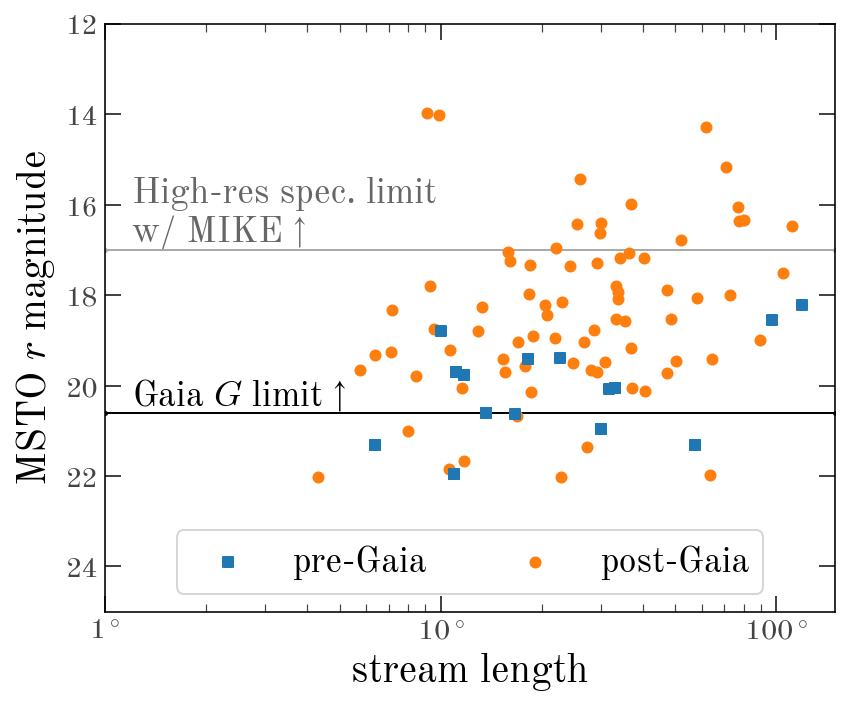

In [110]:
pre_gaia_color = "tab:blue"
pre_gaia_marker = "s"
post_gaia_color = "tab:orange"
post_gaia_marker = "o"


fig, ax = plt.subplots(1, 1, figsize=(6, 5), layout="tight")

ax.scatter(
    pre["size"],
    pre["r"],
    label="pre-Gaia",
    c=pre_gaia_color,
    marker=pre_gaia_marker,
    zorder=100,
)
ax.scatter(
    post["size"],
    post["r"],
    label="post-Gaia",
    c=post_gaia_color,
    marker=post_gaia_marker,
    zorder=10,
)
ax.legend(loc="lower center", ncols=2, fontsize=18)

for row in s5_data:
    ax.scatter(
        row["phi1"].max() - row["phi1"].min(),
        np.mean(row["distmod"]) + MSTO_absmag,
        marker=pre_gaia_marker,
        label=f"{row['name']}",
        c=pre_gaia_color,
        zorder=100,
    )

ax.set(
    xscale="log",
    xlim=(1, 150),
    ylim=(25, 12),
    xticks=[1, 10, 100],
    xticklabels=[r"1$^\circ$", r"10$^\circ$", r"100$^\circ$"],
)


# ax.axhspan(20.6, max(ax.get_ylim()), linewidth=0, zorder=-100, color='#dddddd')
ax.axhline(20.6, linewidth=1, zorder=-100, color="k")
ax.axhline(V, linewidth=1, zorder=-100, color="#aaaaaa", linestyle="-")

ax.text(
    ax.get_xlim()[0] + 0.2,
    20.6,
    "Gaia $G$ limit ↑",
    ha="left",
    va="bottom",
    fontsize=18,
    color="k",
)

ax.text(
    ax.get_xlim()[0] + 0.2,
    V,
    "High-res spec. limit \nw/ MIKE ↑",
    ha="left",
    va="bottom",
    fontsize=18,
    color="#666666",
)

# ax.set_title("Pre-Gaia Streams")
# ax.set_title("Streams Discovered with Gaia")
ax.set_xlabel(r"stream length")
ax.set_ylabel("MSTO $r$ magnitude")

fig.savefig("../tex/figures/msto-rc-mag.pdf")

Text(0, 0.5, 'rough total stellar mass')

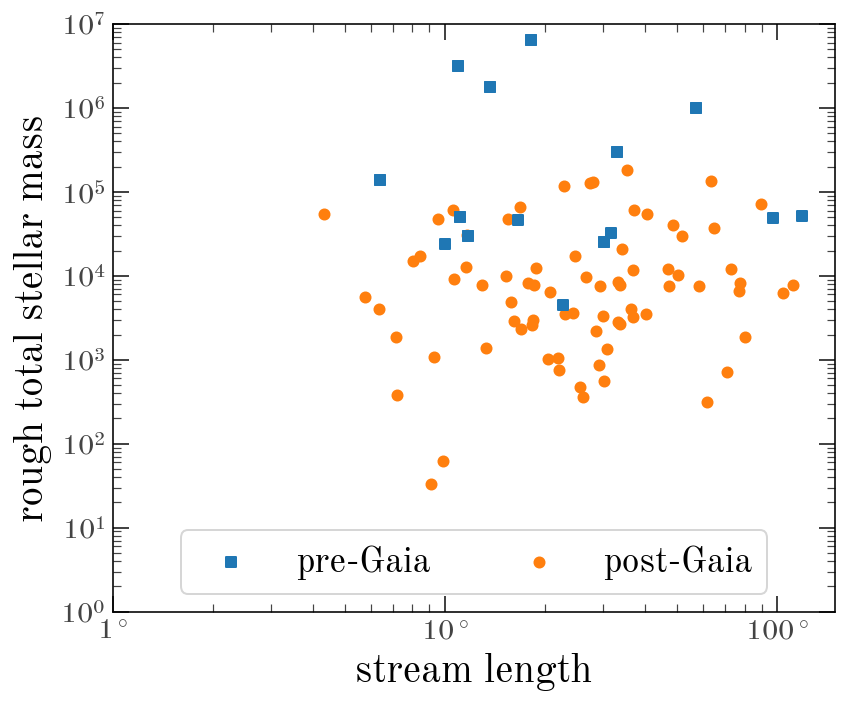

In [111]:
pre_gaia_color = "tab:blue"
pre_gaia_marker = "s"
post_gaia_color = "tab:orange"
post_gaia_marker = "o"


fig, ax = plt.subplots(1, 1, figsize=(6, 5), layout="tight")

ax.scatter(
    pre["size"],
    pre["mass"],
    label="pre-Gaia",
    c=pre_gaia_color,
    marker=pre_gaia_marker,
    zorder=100,
)
# for row in pre:
#     if not np.isfinite(row["mass"]):
#         continue
#     ax.text(row["size"], row["mass"], row["name"])

ax.scatter(
    post["size"],
    post["mass"],
    label="post-Gaia",
    c=post_gaia_color,
    marker=post_gaia_marker,
    zorder=10,
)
ax.legend(loc="lower center", ncols=2, fontsize=18)

for row in s5_data:
    ax.scatter(
        row["phi1"].max() - row["phi1"].min(),
        # np.mean(row["distmod"]) + MSTO_absmag,
        row["mass"],
        marker=pre_gaia_marker,
        label=f"{row['name']}",
        c=pre_gaia_color,
        zorder=100,
    )

ax.set(
    xscale="log",
    yscale="log",
    xlim=(1, 150),
    ylim=(1, 1e7),
    xticks=[1, 10, 100],
    xticklabels=[r"1$^\circ$", r"10$^\circ$", r"100$^\circ$"],
)

# ax.set_title("Pre-Gaia Streams")
# ax.set_title("Streams Discovered with Gaia")
ax.set_xlabel(r"stream length")
ax.set_ylabel("rough total stellar mass")

---

## Sky plot

Plot the sky tracks of all streams - Ibata and S5 streams get color, other galstreams streams gray.

## Prepare stream tracks:

TODO: alpha set by number of stars or stellar mass? or color instead? or surface brightness?

In [112]:
def get_full_galstreams_poly(poly_sc):
    split_i = np.where(np.abs(np.diff(poly_sc.phi2.degree)) > 0.5)[0][0] + 1

    nodes = np.concatenate(
        (
            np.stack((poly_sc.phi1.degree[:split_i], poly_sc.phi2.degree[:split_i])).T,
            np.stack(
                (
                    np.full(128, poly_sc.phi1.degree[split_i]),
                    np.linspace(
                        poly_sc.phi2.degree[split_i - 1],
                        poly_sc.phi2.degree[split_i],
                        128,
                    ),
                )
            ).T,
            np.stack(
                (
                    poly_sc.phi1.degree[split_i + 1 : -1],
                    poly_sc.phi2.degree[split_i + 1 : -1],
                )
            ).T,
            np.stack(
                (
                    np.full(128, poly_sc.phi1.degree[0]),
                    np.linspace(
                        poly_sc.phi2.degree[-2],
                        poly_sc.phi2.degree[0],
                        128,
                    ),
                )
            ).T,
        )
    )

    # reverse order below to make the points wind counter-clockwise = convex
    poly_sc = coord.SkyCoord(
        phi1=nodes[::-1, 0] * u.deg,
        phi2=nodes[::-1, 1] * u.deg,
        frame=poly_sc.frame.replicate_without_data(),
    )
    return poly_sc

In [70]:
ibata_names = [sID_to_name[sid] for sid in all_data.keys()]

track_nodes = {}
for sid, d in all_data.items():
    if sid == 48:
        continue  # skip Orphan

    poly = np.polynomial.Polynomial.fit(
        d["c_fr"].phi1.degree, d["c_fr"].phi2.degree, deg=2
    )
    xgrid = np.linspace(d["c_fr"].phi1.degree.min(), d["c_fr"].phi1.degree.max(), 128)
    mu = poly(xgrid)
    sigma = MAD(d["c_fr"].phi2.degree - poly(d["c_fr"].phi1.degree))

    nodes = np.concatenate(
        (
            np.stack((xgrid, mu - 3 * sigma)).T,
            np.stack(
                (
                    np.full(128, xgrid[-1]),
                    np.linspace(mu[-1] - 3 * sigma, mu[-1] + 3 * sigma, 128),
                )
            ).T,
            np.stack((xgrid, mu + 3 * sigma)).T[::-1],
            np.stack(
                (
                    np.full(128, xgrid[0]),
                    np.linspace(mu[0] - 3 * sigma, mu[0] + 3 * sigma, 128),
                )
            ).T[::-1],
        )
    )
    track_nodes[sid] = coord.SkyCoord(
        phi1=nodes[:, 0] * u.deg,
        phi2=nodes[:, 1] * u.deg,
        frame=d["c_fr"].frame.replicate_without_data(),
    )

    # plt.figure()
    # plt.scatter(d["c_fr"].phi1.degree, d["c_fr"].phi2.degree)
    # plt.fill_between(
    #     xgrid, mu - 3 * sigma, mu + 3 * sigma, color="tab:blue", zorder=-10, alpha=0.5
    # )
    # plt.plot(nodes[:, 0], nodes[:, 1])

# Now add other galstreams tracks for confirmed streams:
tmp = {
    "300S": None,
    "Elqui": None,
    "Jet": "Jet-F22",
    "Orphan": "Orphan-K19",
    "Palca": None,
    "Willka Yaku": None,
    "Turranburra": None,
}
for name, track_name in tmp.items():
    if " " in name:
        name = name.replace(" ", "_")

    if track_name is None:
        track_name = mwstreams.get_track_names_for_stream(name)[0]

    poly_sc = get_full_galstreams_poly(mwstreams[track_name].poly_sc)

    try:
        track_nodes[name_to_sID[name]] = poly_sc
    except KeyError:
        track_nodes[name] = poly_sc

In [72]:
# Now add all other galstreams tracks:
other_track_nodes = {}
for track_name, track in mwstreams.items():
    # These are either not halo streams, or already in the Ibata catalog
    if (
        track.stream_name
        in [
            "Sagittarius",
            "ACS",
            "Monoceros",
            "Cetus-New",
            "Cetus-Palca",
            "OmegaCen-Fimbulthul",
            "M68-Fjorm",
            "Jhelum-a",
            "Jhelum-b",
            "NGC3201-Gjoll",
            "AAU-AliqaUma",
            "AAU-ATLAS",
            "TucIII",
        ]
        or track.stream_name in ibata_names
        or track.stream_name in track_nodes.keys()
    ):
        continue

    poly_sc = get_full_galstreams_poly(mwstreams[track_name].poly_sc)

    try:
        other_track_nodes[name_to_sID[track.stream_name]] = poly_sc
    except KeyError:
        other_track_nodes[track.stream_name] = poly_sc

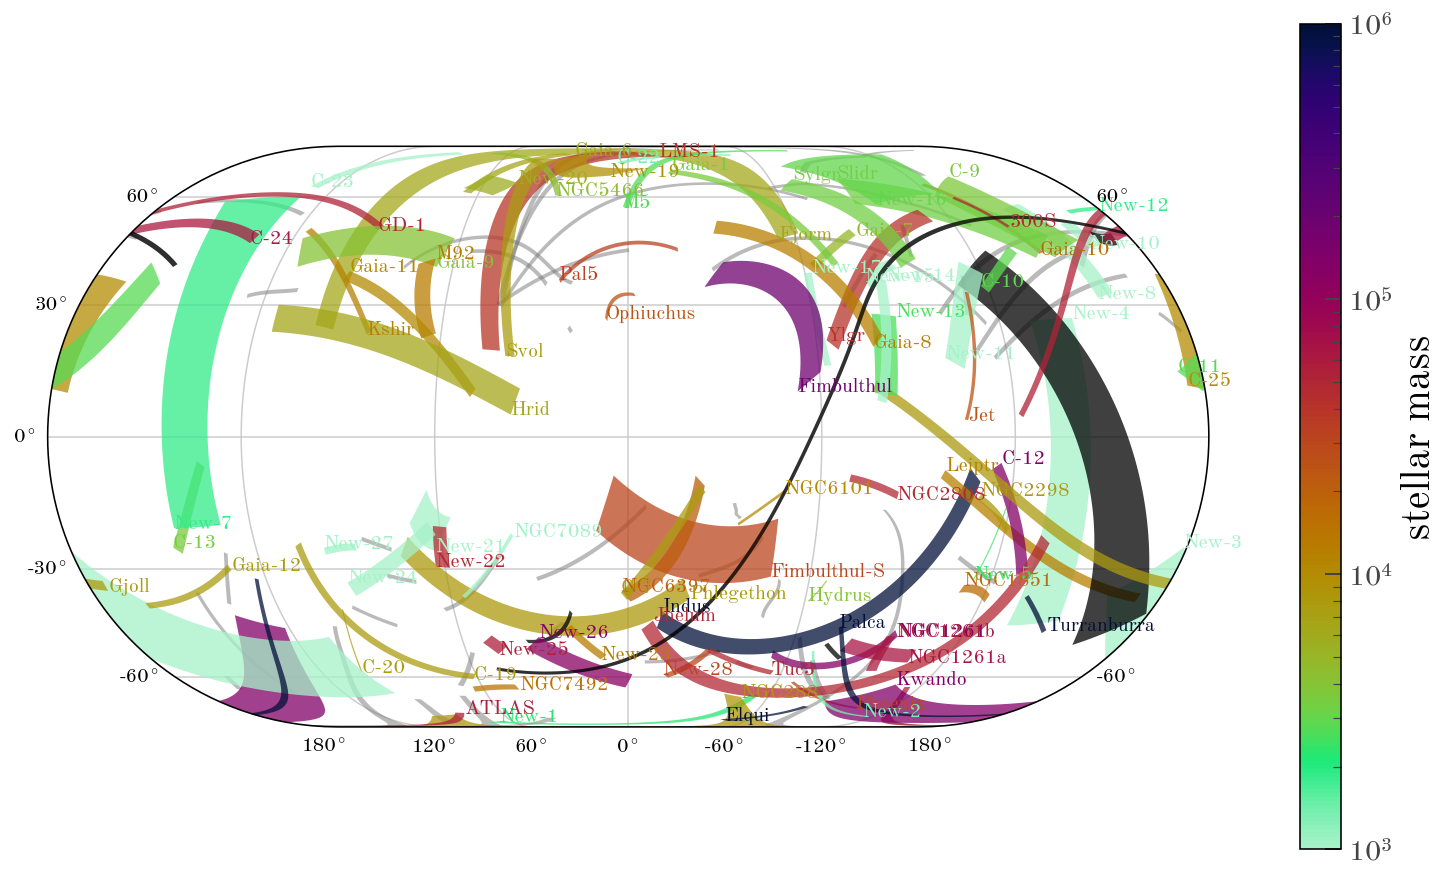

In [130]:
proj = ccrs.EckertIV()
fig, ax = plt.subplots(
    figsize=(10, 6), subplot_kw=dict(projection=proj), layout="constrained"
)
ax.set_global()

norm = mpl.colors.LogNorm(1e3, 1e6)
cmap = cmr.get_sub_cmap(plt.get_cmap("cmr.chroma_r"), start=0.1, stop=0.9)

for sid, track in track_nodes.items():
    if sid in sID_to_name:
        name = sID_to_name[sid]
    else:
        name = sid

    if name in pre["name"]:
        mass = pre[pre["name"] == name]["mass"][0]
    elif name in post["name"]:
        mass = post[post["name"] == name]["mass"][0]
    else:
        mass = np.nan

    color = cmap(norm(mass))

    poly = mpl.patches.Polygon(
        np.stack(
            # (track.galactic.l.wrap_at(180 * u.deg).radian, track.galactic.b.radian)
            (track.galactic.l.wrap_at(180 * u.deg).degree, track.galactic.b.degree)
        ).T,
        color=color,
        alpha=0.75,
        transform=ccrs.Geodetic(),
        linewidth=0,
    )
    ax.add_patch(poly)

    ax.text(*poly.get_xy()[0], name, color=color, fontsize=10, transform=ccrs.Geodetic())

    # d = all_data[sid]
    # (l,) = ax.plot(
    #     track.galactic.l.wrap_at(180 * u.deg).degree,
    #     track.galactic.b.degree,
    #     color="tab:blue",
    #     alpha=0.5,
    #     zorder=-10,
    #     marker="",
    #     lw=1,
    #     transform=ccrs.Geodetic()
    # )
    # ax.scatter(d["c_fr"].galactic.l.wrap_at(180 * u.deg).degree, d["c_fr"].galactic.b.degree, c=l.get_color(), transform=ccrs.Geodetic())

for track in other_track_nodes.values():
    poly = mpl.patches.Polygon(
        np.stack(
            # (track.galactic.l.wrap_at(180 * u.deg).radian, track.galactic.b.radian)
            (track.galactic.l.wrap_at(180 * u.deg).degree, track.galactic.b.degree)
        ).T,
        color="#777777",
        linewidth=0,
        alpha=0.5,
        transform=ccrs.Geodetic(),
        zorder=-10,
    )
    ax.add_patch(poly)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm, ax=ax)
cb.set_label("stellar mass")

lon_formatter = LongitudeFormatter(zero_direction_label=True, direction_label=False)
lat_formatter = LatitudeFormatter(direction_label=False)
gl = ax.gridlines(
    draw_labels=True,
    xformatter=lon_formatter,
    yformatter=lat_formatter,
    color="#cccccc",
    zorder=-25
)
gl.top_labels = False
gl.right_labels = False

ax.invert_xaxis()

TODO: there are more classes:
- pre-gaia discovered, gaia confirmed
- pre-gaia discovered, unconfirmed
- post-gaia discovered, confirmed
- post-gaia discovered, unconfirmed

In [134]:
sorted(post['name'])

['ATLAS',
 'C-10',
 'C-11',
 'C-12',
 'C-13',
 'C-19',
 'C-20',
 'C-22',
 'C-23',
 'C-24',
 'C-25',
 'C-7',
 'C-9',
 'Fimbulthul',
 'Fimbulthul-S',
 'Fjorm',
 'Gaia-1',
 'Gaia-10',
 'Gaia-11',
 'Gaia-12',
 'Gaia-6',
 'Gaia-7',
 'Gaia-8',
 'Gaia-9',
 'Gjoll',
 'Hrid',
 'Hydrus',
 'Indus',
 'Kshir',
 'Kwando',
 'LMS-1',
 'Leiptr',
 'M5',
 'M92',
 'NGC1261',
 'NGC1261a',
 'NGC1261b',
 'NGC1851',
 'NGC2298',
 'NGC2808',
 'NGC288',
 'NGC6101',
 'NGC6397',
 'NGC7089',
 'NGC7492',
 'New-1',
 'New-10',
 'New-11',
 'New-12',
 'New-13',
 'New-14',
 'New-15',
 'New-16',
 'New-17',
 'New-19',
 'New-2',
 'New-20',
 'New-21',
 'New-22',
 'New-23',
 'New-24',
 'New-25',
 'New-26',
 'New-27',
 'New-28',
 'New-3',
 'New-4',
 'New-5',
 'New-7',
 'New-8',
 'Phlegethon',
 'Phoenix',
 'Slidr',
 'Svol',
 'Sylgr',
 'Ylgr']

In [117]:
for name in post[post['mass'] > 8e4]["name"]:
    d = all_data[name_to_sID[name]]
    break

(-90.0, 90.0)

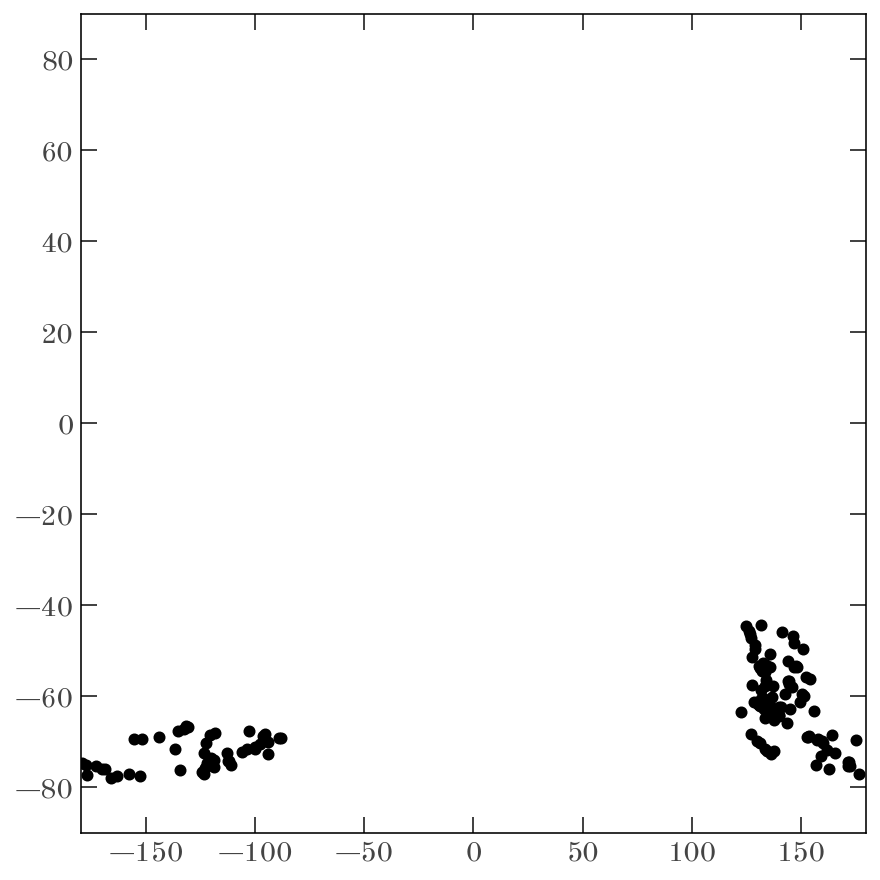

In [125]:
plt.scatter(
    d['c_fr'].galactic.l.wrap_at(180*u.deg).degree,
    d['c_fr'].galactic.b.degree
)
plt.xlim(-180, 180)
plt.ylim(-90, 90)

In [115]:
post[post['mass'] > 8e4]

name,size,r,mass
str12,float64,float64,float64
Kwando,63.61565298799118,21.989015637750224,134202.08110473832
NGC1261,27.326183415098136,21.369562287750682,126204.59734897809
C-12,28.0143524416658,19.648564218533988,130898.07492470474
Fimbulthul,35.464912546497494,18.56706462358757,182117.56167863085
New-26,22.83032908322774,22.022804600860265,117669.94067879229
